# Example for processing proximity data collected by a hub

The badges scans for other badges and iBeacons every time interval. The time interval, called time_slice in this example, is set by the hub and usually configured for 60 seconds.

Each scan appears as a JSON object, containing the member key of the scanning badge, it's MAC address, timestamp of the scan, voltage at the time of the scan, and a list of other bluetooth devices picked up by the scan. 

In order to preserve storage space, we do not save the MAC addresses of the the badges found in th scan. Instead, we store only the badge ID - a 16-bit unique identifier that each badge broadcasts. This ID can be set manually, but at the time of writing this example, the ID is created using CRC16 based on the MAC address. 

Since members may change their badges during the experiment, it's important to perform the analysis using member keys.

Code credits - Xavier Lambein

In [1]:
import os, sys
import logging
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [2]:
ob.__version__

'0.4.4'

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to your local time.

In [3]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filenames = []

for i in range(1, 18):
    if i < 10:
        filename = 'CTSIserver{:02d}_proximity_2019-06-01.txt'.format(i)
    else:
        filename = 'CTSIserver{}_proximity_2019-06-01.txt'.format(i)
        
    proximity_data_filenames.append(filename)
    
members_metadata_filename = "Member-2019-05-28.csv"
beacons_metadata_filename = "location table.xlsx"
data_dir = "../Rhythm Badge Analysis File/proximity_2019-06-01/"

# Pre-processing

First, we load two lists that will help us with some of the analysis: list of membmers and list of location beacons

In [32]:
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
beacons_metadata = pd.read_excel(data_dir+beacons_metadata_filename, sheet_name='Sheet1')

# Calculating the id of the beacon based on it's MAC address
# beacons_metadata['id'] = beacons_metadata.apply(
#     lambda row: ob.core.mac_address_to_id(row['badge_address']),
#     axis=1
# )

## beacons_metadata

We create a translation table between the badge ID and member key. This is done based on the data itself, since it should contain data from all the badges that take part in the study. 

Note that we create a <id,member key> pair for ever time bin. While this is not necessary at this point, it allows this mapping to change (for example, if a badge is re-assigned to a different member).

In [5]:
idmaps = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        idmaps.append(ob.preprocessing.id_to_member_mapping(f, time_bins_size, tz=time_zone))

Using this translation table and the proximity data, we can create a list of "pings" - every time two badges were in close proximity

In [6]:
m2badges = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        m2badges.append(ob.preprocessing.member_to_badge_proximity(f, time_bins_size, tz=time_zone))

Since a badge can either be a badge worn by a participant, or a location beacon, we split the dataset into member-to-member (for network graphs) and member-to-beacon (for localization)

In [7]:
# Member to member
m2ms = []
for (m2badge, idmap) in zip(m2badges, idmaps):
    m2ms.append(ob.preprocessing.member_to_member_proximity(m2badge, idmap))

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 09:27:00-04:00 2J8MAVR3AS MVYAANIGBF     -79.0          -79.000000   
2019-06-01 09:28:00-04:00 2J8MAVR3AS MVYAANIGBF     -80.0          -80.000000   
2019-06-01 09:29:00-04:00 2J8MAVR3AS MVYAANIGBF     -77.0          -77.000000   
2019-06-01 09:30:00-04:00 2J8MAVR3AS MVYAANIGBF     -79.0          -79.000000   
2019-06-01 09:31:00-04:00 2J8MAVR3AS MVYAANIGBF     -77.0          -77.000000   
2019-06-01 09:36:00-04:00 MVYAANIGBF Y0ZAKX140I     -80.0          -80.000000   
2019-06-01 09:37:00-04:00 2J8MAVR3AS Y0ZAKX140I     -85.0          -85.000000   
                          MVYAANIGBF Y0ZAKX140I     -81.0          -81.000000   
2019-06-01 09:38:00-04:00 MVYAANIGBF Y0ZAKX140I     -82.0          -82.000000   
2019-06-01 09:39:00-04:00 2J8MAVR3AS Y0ZAKX140I     -80.0          -80.000000   
                          MV

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:03:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:05:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:06:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:09:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:12:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:13:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:16:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:22:00-04:00 IKU71LTZ93 MKFK72B1N6     -55.0          -55.000000   
2019-06-01 00:23:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:25:00-04:00 IKU71LTZ93 MKFK72B1N6     -56.0          -56.000000   
2019-06-01 00:27:00-04:00 IK

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:30:00-04:00 N87XWKDN63 ORCY5PX3BG     -44.0          -44.571429   
2019-06-01 00:31:00-04:00 N87XWKDN63 ORCY5PX3BG     -44.0          -44.000000   
2019-06-01 00:32:00-04:00 N87XWKDN63 ORCY5PX3BG     -44.0          -44.571429   
2019-06-01 00:33:00-04:00 1ZZAV6Q1XG N87XWKDN63     -51.0          -51.000000   
                                     ORCY5PX3BG     -49.0          -50.000000   
                          N87XWKDN63 ORCY5PX3BG     -44.0          -44.200000   
2019-06-01 00:34:00-04:00 1ZZAV6Q1XG N87XWKDN63     -48.0          -50.000000   
                                     ORCY5PX3BG     -48.0          -49.333333   
                          N87XWKDN63 ORCY5PX3BG     -44.0          -44.000000   
2019-06-01 00:35:00-04:00 1ZZAV6Q1XG N87XWKDN63     -48.0          -49.714286   
                            

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:00:00-04:00 2CJG5KK4I9 7AVP31LZU1     -47.0          -48.000000   
                                     81BK4LF47T     -44.0          -44.000000   
                                     89YYUWCROB     -44.0          -44.000000   
                                     N87XWKDN63     -58.0          -58.000000   
                                     YT7HBOM7D9     -48.0          -49.000000   
                          7AVP31LZU1 81BK4LF47T     -51.0          -51.888889   
                                     89YYUWCROB     -45.0          -46.500000   
                                     N87XWKDN63     -51.0          -51.500000   
                          81BK4LF47T 89YYUWCROB     -44.0          -44.000000   
                                     N87XWKDN63     -55.0          -55.000000   
                            

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:00:00-04:00 5VTQOYMDXP N7X3CND9H8     -44.0          -44.000000   
                                     YC4RB5ME6H     -45.0          -45.000000   
                          EW805JKEIB F4VB4QJ7G8     -44.0          -44.000000   
                                     J9NE9U783O     -44.0          -44.600000   
                          F4VB4QJ7G8 J9NE9U783O     -44.0          -45.142857   
                          N7X3CND9H8 YC4RB5ME6H     -45.0          -45.000000   
2019-06-01 00:01:00-04:00 5VTQOYMDXP N7X3CND9H8     -44.0          -44.428571   
                                     YC4RB5ME6H     -45.0          -45.000000   
                          EW805JKEIB F4VB4QJ7G8     -44.0          -44.000000   
                                     J9NE9U783O     -44.0          -44.666667   
                          F4

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:00:00-04:00 6FI0Z5BPM9 BGDAR6QAZ4     -44.0          -44.500000   
                                     XWX0GF9XXM     -51.0          -51.333333   
                                     YOMIDAL72I     -52.0          -52.333333   
                          BGDAR6QAZ4 O362RWVN8T     -46.0          -47.250000   
                                     PNVAQ4FSKG     -45.0          -45.800000   
                                     XWX0GF9XXM     -44.0          -44.000000   
                                     YOMIDAL72I     -46.0          -46.000000   
                          O362RWVN8T PNVAQ4FSKG     -44.0          -44.000000   
                                     XWX0GF9XXM     -48.0          -48.545455   
                                     YOMIDAL72I     -48.0          -48.750000   
                          PN

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:44:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:45:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:46:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:47:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:48:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:49:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:50:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:51:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:52:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:53:00-04:00 3G3F81BBVO O0GD44NFBO     -44.0          -44.000000   
2019-06-01 00:54:00-04:00 3G

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 08:03:00-04:00 2J8MAVR3AS PNVAQ4FSKG     -77.0          -77.000000   
2019-06-01 08:08:00-04:00 2J8MAVR3AS YOMIDAL72I     -74.0          -74.000000   
                          PNVAQ4FSKG YOMIDAL72I     -69.0          -69.000000   
2019-06-01 08:09:00-04:00 2J8MAVR3AS YOMIDAL72I     -71.0          -71.000000   
                          PNVAQ4FSKG YOMIDAL72I     -67.0          -67.000000   
2019-06-01 08:10:00-04:00 2J8MAVR3AS YOMIDAL72I     -72.0          -72.000000   
                          PNVAQ4FSKG YOMIDAL72I     -70.0          -70.000000   
2019-06-01 08:11:00-04:00 2J8MAVR3AS YOMIDAL72I     -76.0          -76.000000   
                          PNVAQ4FSKG YOMIDAL72I     -62.0          -62.000000   
2019-06-01 08:12:00-04:00 PNVAQ4FSKG YOMIDAL72I     -75.0          -75.000000   
2019-06-01 08:13:00-04:00 2J

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 01:27:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.500000   
2019-06-01 01:28:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.555556   
2019-06-01 01:29:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.400000   
2019-06-01 01:30:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.500000   
2019-06-01 01:31:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.500000   
2019-06-01 01:32:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.500000   
2019-06-01 01:33:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.500000   
2019-06-01 01:34:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.000000   
2019-06-01 01:35:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -46.0          -46.500000   
2019-06-01 01:36:00-04:00 1ZZAV6Q1XG UTAH98VIOQ     -47.0          -47.800000   
2019-06-01 01:37:00-04:00 1Z

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 01:38:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.571429   
2019-06-01 01:39:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -46.200000   
2019-06-01 01:40:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.714286   
2019-06-01 01:41:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.428571   
2019-06-01 01:42:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.625000   
2019-06-01 01:43:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.500000   
2019-06-01 01:44:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.428571   
2019-06-01 01:45:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.571429   
2019-06-01 01:46:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -45.0          -45.666667   
2019-06-01 01:47:00-04:00 2JYFJA84HQ O2X9FPB1Y1     -46.0          -46.000000   
2019-06-01 01:48:00-04:00 2J

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 01:42:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:43:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:44:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:45:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:46:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:47:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:48:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:49:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:50:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:51:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0          -52.000000   
2019-06-01 01:52:00-04:00 DG

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 01:57:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.625000   
2019-06-01 01:58:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.600000   
2019-06-01 01:59:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -50.0          -50.500000   
2019-06-01 02:00:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.571429   
2019-06-01 02:01:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -50.0          -50.428571   
2019-06-01 02:02:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.428571   
2019-06-01 02:03:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.428571   
2019-06-01 02:04:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.444444   
2019-06-01 02:05:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.833333   
2019-06-01 02:06:00-04:00 0UQCHL9WC9 IG8ZAKUAIT     -49.0          -49.600000   
2019-06-01 02:07:00-04:00 0U

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 01:43:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:44:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:45:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:46:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:47:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:48:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:49:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
2019-06-01 01:50:00-04:00 BB5MIZA6T9 V0CDWYOMW6     -51.0          -51.000000   
                                     WO2LI35VPN     -44.0          -44.571429   
                          V0CDWYOMW6 WO2LI35VPN     -47.0          -47.285714   
2019-06-01 01:51:00-04:00 BB

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:00:00-04:00 8Y9U3OEV58 ASGTO01DNR     -44.0          -44.000000   
                          ASGTO01DNR KZRNONJ61I     -44.0          -44.000000   
                                     U242CQ4MX8     -44.0          -44.000000   
                          KZRNONJ61I U242CQ4MX8     -45.0          -45.000000   
2019-06-01 00:01:00-04:00 8Y9U3OEV58 ASGTO01DNR     -44.0          -44.000000   
                          ASGTO01DNR EJCJZNKPMG     -44.0          -44.000000   
                                     KZRNONJ61I     -44.0          -44.000000   
                                     U242CQ4MX8     -44.0          -44.000000   
                          EJCJZNKPMG U242CQ4MX8     -44.0          -44.000000   
                          KZRNONJ61I U242CQ4MX8     -45.0          -45.000000   
2019-06-01 00:02:00-04:00 8Y

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:42:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:43:00-04:00 2ZNIW64VDH OHRS4FV3S7     -45.0          -45.333333   
2019-06-01 00:44:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:45:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:46:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:47:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -47.250000   
2019-06-01 00:48:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:49:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:50:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -47.000000   
2019-06-01 00:51:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:52:00-04:00 2Z

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 10:10:00-04:00 8Y9U3OEV58 YMEJFJPF66     -84.0          -85.000000   
2019-06-01 10:11:00-04:00 8Y9U3OEV58 YMEJFJPF66     -90.0          -90.000000   
2019-06-01 10:13:00-04:00 8Y9U3OEV58 YMEJFJPF66     -98.0          -98.000000   
2019-06-01 10:14:00-04:00 8Y9U3OEV58 YMEJFJPF66     -88.0          -88.000000   
2019-06-01 10:15:00-04:00 8Y9U3OEV58 YMEJFJPF66     -91.0          -91.000000   
2019-06-01 10:16:00-04:00 8Y9U3OEV58 YMEJFJPF66     -97.0          -97.000000   
2019-06-01 10:17:00-04:00 8Y9U3OEV58 YMEJFJPF66     -87.0          -88.000000   
2019-06-01 10:19:00-04:00 8Y9U3OEV58 YMEJFJPF66     -89.0          -89.000000   
2019-06-01 10:21:00-04:00 OHRS4FV3S7 YMEJFJPF66     -92.0          -92.000000   
2019-06-01 10:22:00-04:00 OHRS4FV3S7 YMEJFJPF66     -90.0          -90.000000   
2019-06-01 10:23:00-04:00 8Y

In [8]:
# Member to location beacon
m2bs = []
for m2badge in m2badges:
    m2bs.append(ob.preprocessing.member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon']))

 Member 5 closest beacons

In [25]:
m5cb = m2bs[12].reset_index().groupby(['datetime', 'member'])['rssi', 'beacon'] \
        .apply(lambda x: x.nlargest(5, columns=['rssi']) \
        .reset_index(drop=True)[['beacon']]).unstack()['beacon'].fillna(-1).astype(int)

Next, we extract voltage data from the files. This information can be used for monitoring purposes and for identifying badges that ran out of power prematurely.

In [10]:
with open(os.path.join(data_dir, proximity_data_filenames[13]), 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone)

# Basic examples

## Example 1 - Network graph
This example shows how to build a basic proximity network using the badge data.

In [11]:
# Filter data from specific time period

m2m_tmp = m2ms[12] # choose the beacon 13 file to do test

time_slice = slice('2019-06-01 9:50', '2019-06-01 11:30')
m2m_breakout = m2m_tmp.loc[time_slice]

# keep only instances with strong signal
m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -70].copy()
print(len(m2m_filter_rssi))

1558


In [12]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges = m2m_edges[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges = m2m_edges[m2m_edges.weight > 15]
print(len(m2m_edges))

# Create a graph
graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")

31


In [13]:
# set colors by region
regions = members_metadata["region"].unique()
len_regions = len(regions)
value_map = {}
for i in range(0,len_regions):
    value_map[regions[i]] = i * (1.0/(len_regions-1))

In [14]:
# Add node information. Assign color
for index, row in members_metadata.iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map.get(region)
    if member in graph.nodes():        
        graph.add_node(member, region=region, color = color)
        
node_colors = [color for member,color in nx.get_node_attributes(graph, 'color').iteritems()]

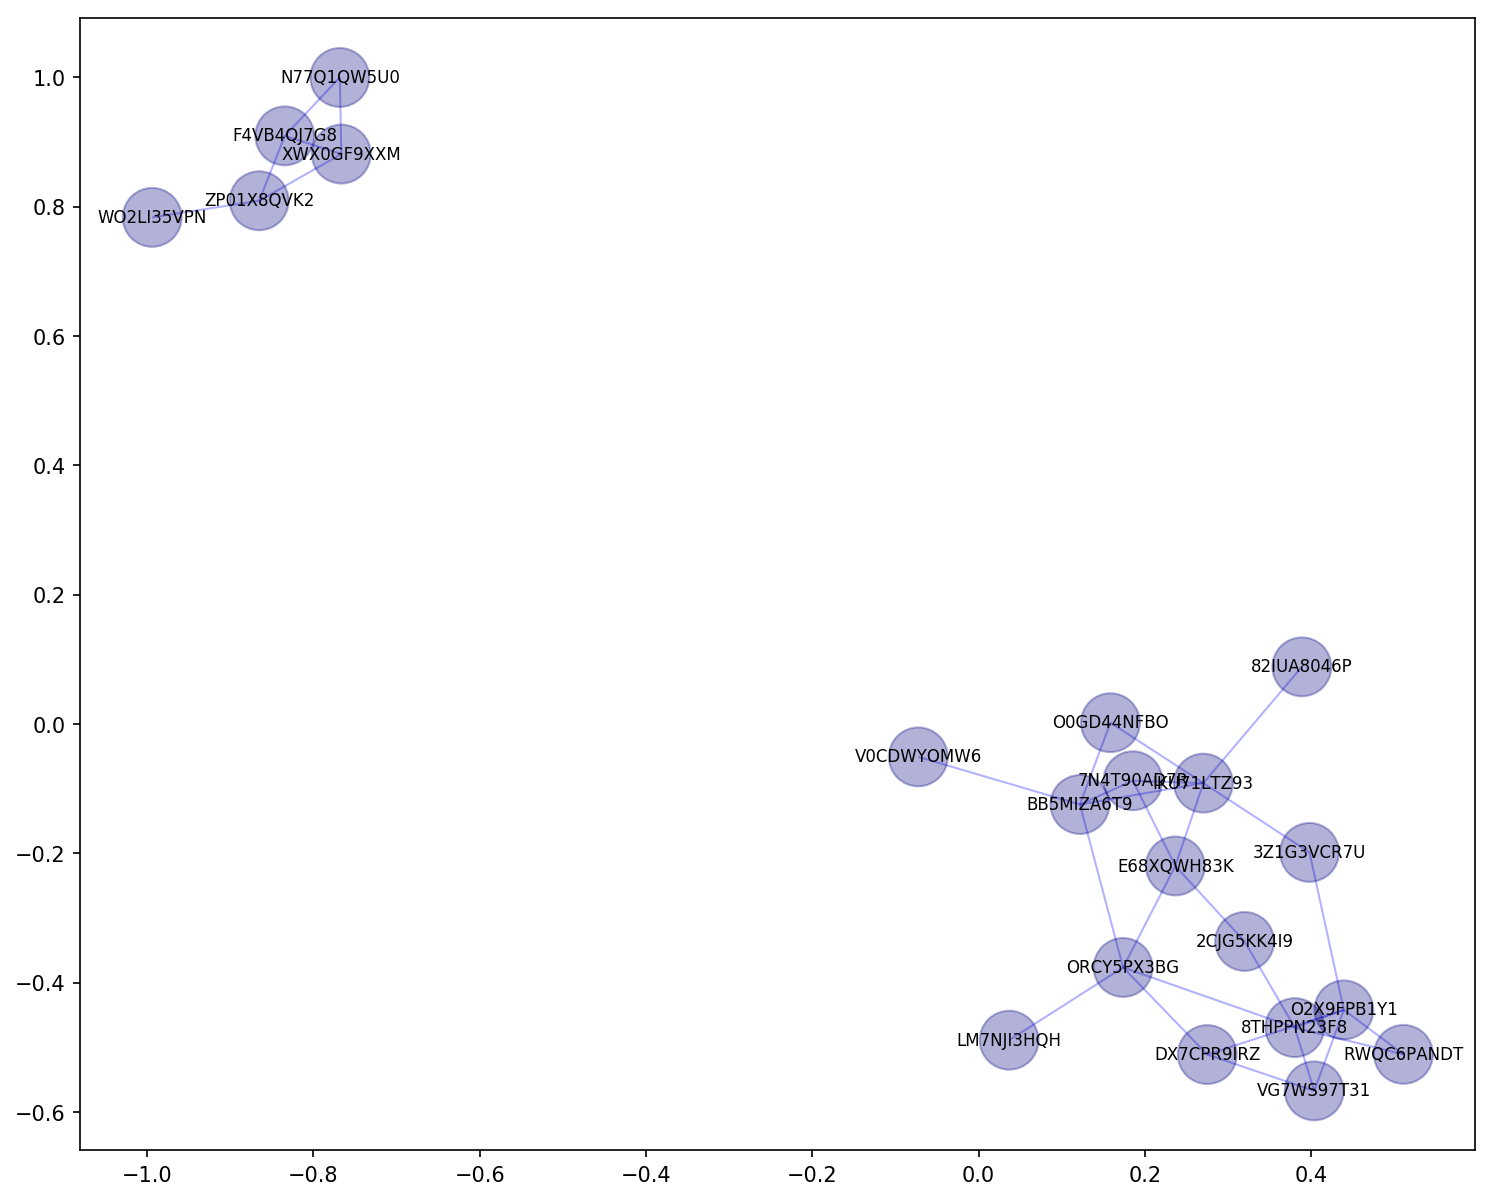

In [15]:
def draw_graph(G, graph_layout='shell',
               node_size=800, node_color='blue', node_alpha=0.3,
               node_text_size=8,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    plt.show()

fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

draw_graph(graph, graph_layout="spring", node_color = node_colors)

## Example 2 - Voltage heatmap
In this exmaple we simply plot a heatmap showing the voltage values of all badges. The figure shows that:
* At this specific day some badges were left at the experiment site overnight 
* Participants started to arrive around 8am

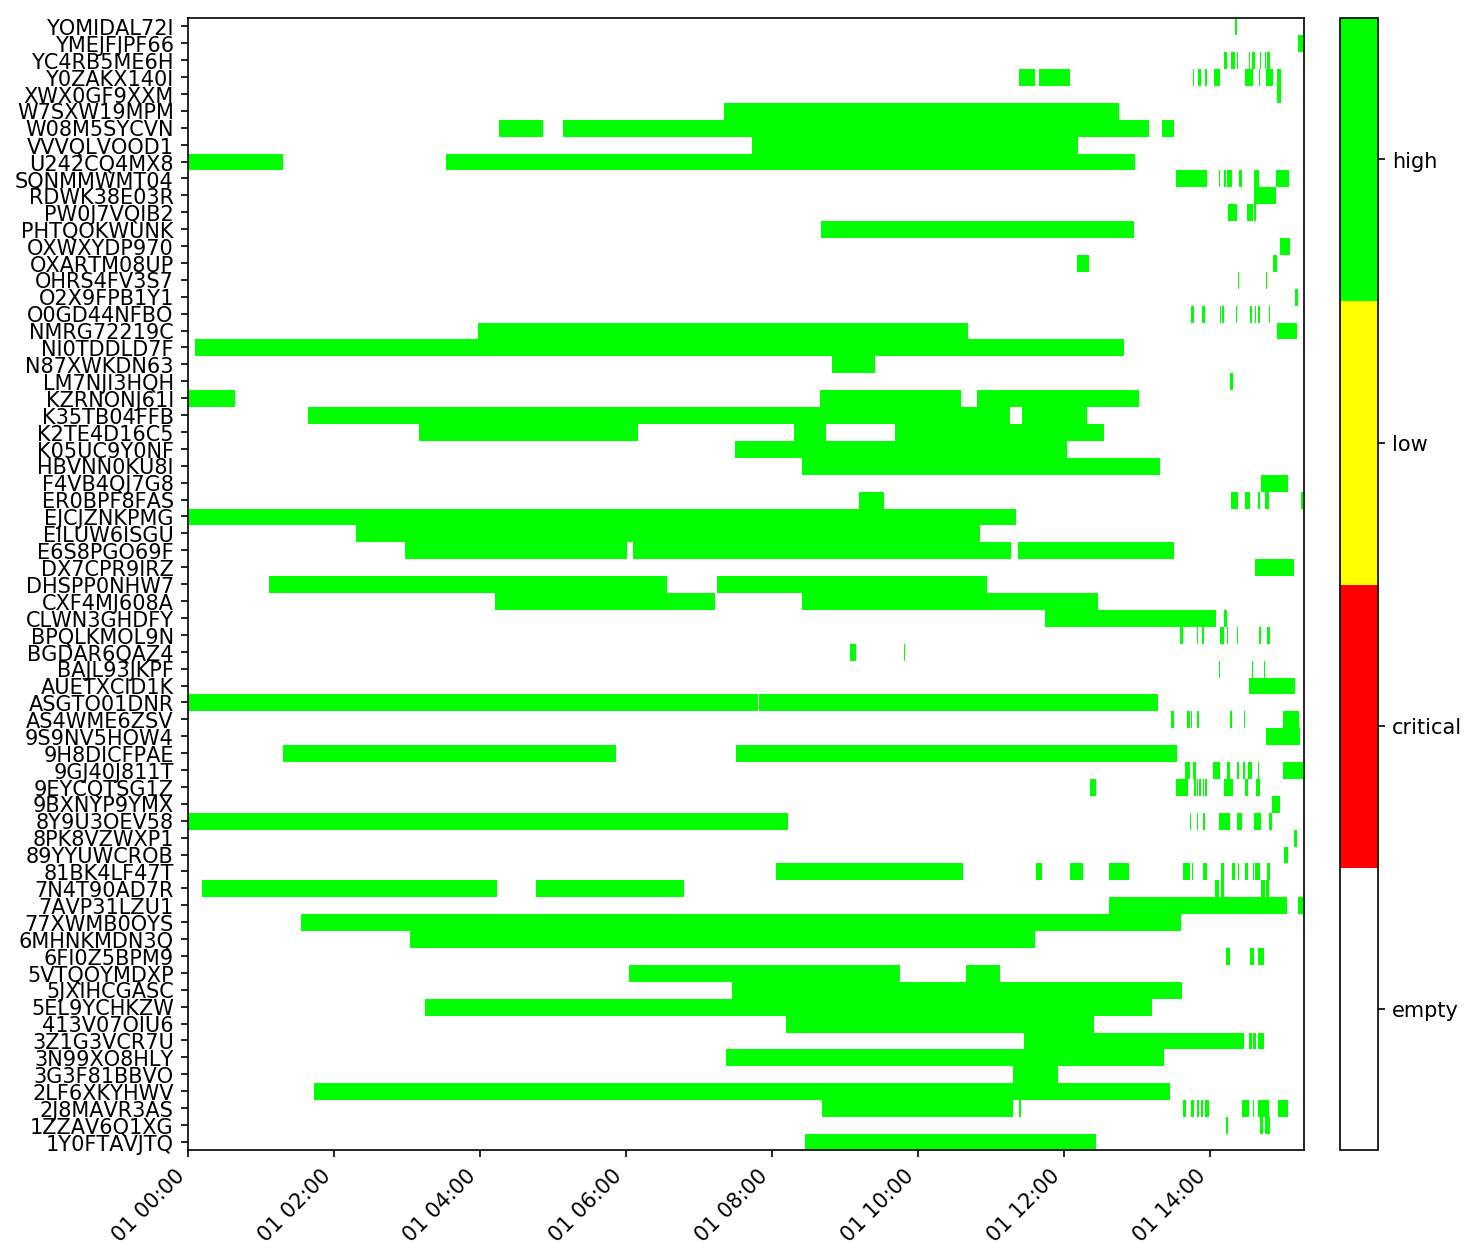

In [16]:
## TODO: Only select members who were scanned by Beacon 13


# The maximum voltage, to be used as an upper bound
max_voltage = voltages.max()

# Create the color map for the various battery levels
cmap = mpl.colors.ListedColormap(['white', 'red', 'yellow', 'lime'])
bounds = [0.0, 0.001, 2.4, 2.5, max_voltage]
levels = ['empty', 'critical', 'low', 'high']
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

pivoted = voltages.unstack(0).fillna(0.0)

fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

# Create the time-location diagram
coll = ax.pcolor(pivoted, cmap=cmap, norm=norm)

# Set the y ticks (members)
ax.set_yticks(np.arange(0.5, len(pivoted.index), 1))
ax.set_yticklabels(pivoted.index)

# Set the x ticks (dates)
xlabels = pd.date_range(pivoted.columns[0], pivoted.columns[-1], freq='2h')
ax.set_xticks([pivoted.columns.get_loc(idx, method='nearest') for idx in xlabels])
ax.set_xticklabels(xlabels.strftime('%d %H:%M'), rotation=45, ha='right')

# Add a colorbar, with one tick per location
cbar = plt.colorbar(coll, use_gridspec=False,
                    anchor=(-.2, 0.5), aspect=30,)
cbar.set_ticks((np.array(bounds[1:]) + np.array(bounds[:-1]))/2)
cbar.set_ticklabels(levels)

plt.show()

## Example 3 - Closest Beacon Localization
This example places each badge near the closest beacon for each time interval. You can immediately see that the teams spent more of the time in the classrom, but head a breakout session in the afternoon (different teams went ot different rooms).

You can also see that some badges stayed at the reception area for the majority of the time - these badges belong to participants who did not show up for the event, and should therefore be removed from the analysis.

In [33]:
members_metadata = members_metadata.set_index('member')
beacons_metadata = beacons_metadata.set_index('beacon')

In [34]:
# Take the closest beacon
closest = m5cb[0].rename('beacon')

In [35]:
# Go from closest beacon to location using the metadata
locations = closest.to_frame().join(beacons_metadata['location'], on='beacon')

# Join people's region for sorting
locations = locations.join(members_metadata['region'])

# Add the region to the index
locations = locations.reset_index().set_index(['datetime', 'region', 'member']).sort_index()

locations = locations['location']
locations.head()

datetime                   region  member    
2019-06-01 00:14:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:15:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:16:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:17:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:18:00-04:00  Team1   V0CDWYOMW6    Café
Name: location, dtype: object

In [36]:
locations

datetime                   region  member    
2019-06-01 00:14:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:15:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:16:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:17:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:18:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:19:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:20:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:21:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:22:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:23:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:24:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:25:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:26:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:27:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:28:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:29:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:30:00-04:00  Team1   V0CDWYOMW6    Café
2019-06-01 00:31:00-04:00  Team1   V

In [37]:
def time_location_plot(time_locations, ax=None, cmap=None, freq='30min', datetime_format='%H:%M'):
    """Plots the location of individuals/groups of individuals as a function of time.
    
    Parameters
    ----------
    time_locations : pd.Series
        The locations, indexed by 'datetime' and another index (e.g. member, group, ...).
    
    ax : matplotlib axes
        The axes on which to plot.
    
    cmap : matplotlib.colors.Colormap or str
        The colormap used by matplotlib.
    
    freq : str
        The frequency of ticks on the x-axis.  Defaults to '30min'.
    
    datetime_format : str
        The way time is formatted with `strftime` on the x-axis.
        See https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
        for more information.
    """

    # Pivot the dataframe to have datetime vs member
    pivoted = time_locations.unstack(0)

    # The list of locations
    locations = sorted(set(time_locations))
    N = len(locations)

    # Select a colormap (either passed, string or default)
    if cmap is None:
        cmap = plt.get_cmap('tab10')  # Default colormap
    elif type(cmap) is str:
        cmap = plt.get_cmap(cmap)

    if ax is None:
        ax = plt.gca()  # Use current axes if none were provided

    # Construct a colormap based on `cmap` that matches the number of different locations,
    # and displays `None` as white
    cmap = mpl.colors.ListedColormap([(1.0, 1.0, 1.0)] + list(cmap.colors), N=N+1)

    # Map locations to integers, to be used by `pcolor`
    mapping = {loc: i+1 for (i, loc) in enumerate(locations)}
    pivoted = pivoted.applymap(lambda x: mapping.get(x, 0))

    # Create the time-location diagram
    coll = ax.pcolormesh(pivoted, cmap=cmap)

    # Vertical axis, with the people
    ax.set_yticks(np.arange(0.5, len(pivoted.index), 1))
    ax.set_yticklabels(pivoted.index)

    # Horizontal axis, with the dates
    xlabels = pd.date_range(pivoted.columns[0], pivoted.columns[-1], freq=freq)
    ax.set_xticks([pivoted.columns.get_loc(idx, method='nearest') for idx in xlabels])
    ax.set_xticklabels(xlabels.strftime(datetime_format), rotation=45, ha='right')

    # Add a colorbar, with one tick per location
    cbar = ax.figure.colorbar(coll, use_gridspec=False,
                              anchor=(-.2, 0.5), aspect=30,
                              boundaries=np.arange(0, N+1)+.5)
    cbar.set_ticks(np.arange(1., N+1, 1.))
    cbar.set_ticklabels(locations)

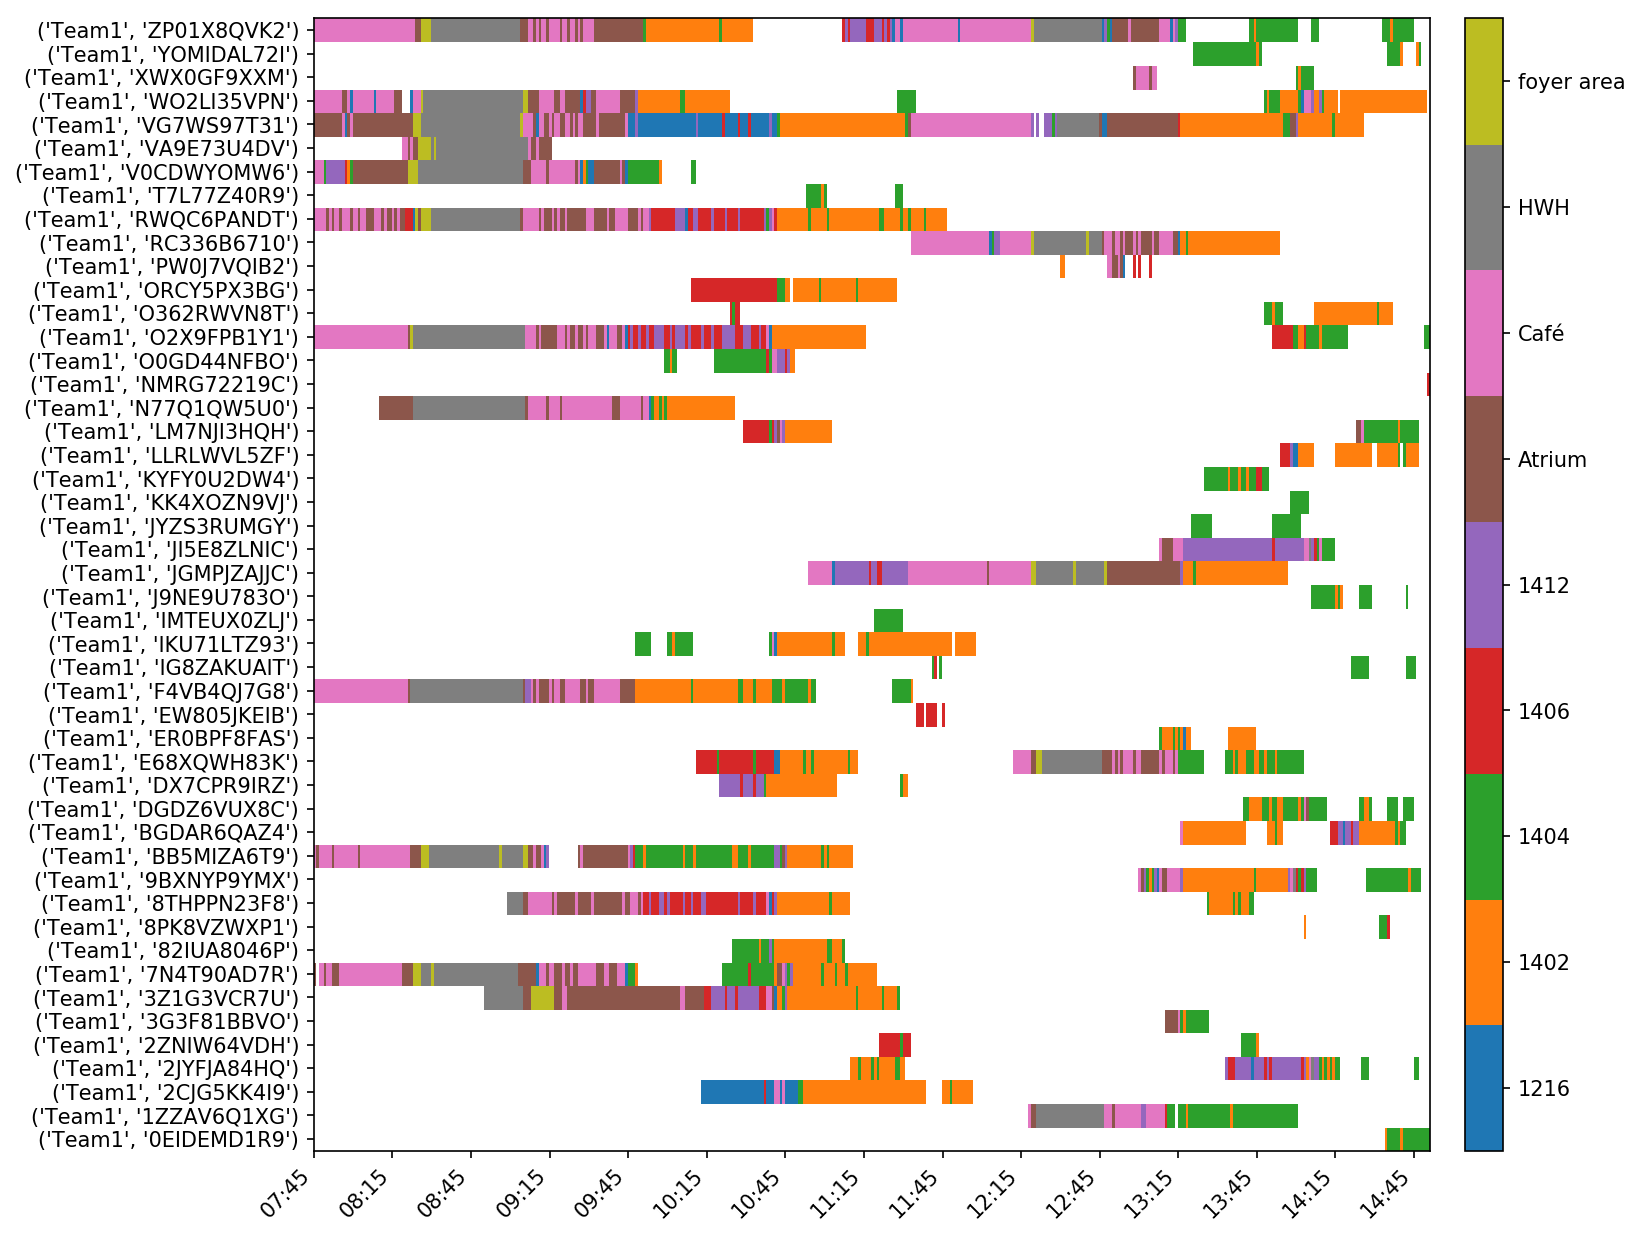

In [38]:
# The time slice for displaying the heatmap
time_slice = slice('2019-06-01 07:45', '2019-06-01 14:50')

# Plotting
fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

time_location_plot(locations.loc[time_slice])

plt.show()